In [768]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [743]:
games = pd.read_csv('../input/nba-games/games.csv')
details = pd.read_csv('../input/nba-games/games_details.csv')
teams = pd.read_csv('../input/nba-games/teams.csv')
players = pd.read_csv('../input/nba-games/players.csv')
ranking = pd.read_csv('../input/nba-games/ranking.csv')

C:\Users\Clay\AppData\Local\Temp\ipykernel_97368\977498853.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv('../input/nba-games/games_details.csv')


In [744]:
def get_labels(ranking):
    temp = ranking.copy(deep=False)
    temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()
    temp = pd.DataFrame(temp)
    temp.reset_index(inplace=True)
    drops = []
    for i in range(len(temp)):
        if temp.iloc[i,1] / 10000 > 2:
            temp.iloc[i,1] = temp.iloc[i,1] % 10000
        else:
            drops.append(i)
            continue;
        if (temp.iloc[i,2] != 82):
            drops.append(i)
    for i in range(len(drops)):
        temp.drop([drops[i]], inplace=True)
    temp.reset_index(inplace=True)
    temp.drop(columns=['index'], inplace=True)
    temp.drop(columns=['G'], inplace=True)
#     temp = pd.merge(temp, ranking, how='left', left_on=['TEAM_ID','STANDINGSDATE'], right_on = ['TEAM_ID','STANDINGSDATE'])
#     temp.drop(columns=['STANDINGSDATE','LEAGUE_ID','SEASON_ID_y','CONFERENCE','TEAM','G','W','L','HOME_RECORD','ROAD_RECORD','RETURNTOPLAY'], inplace=True)
    return temp

In [745]:
labels = get_labels(ranking)
labels

C:\Users\Clay\AppData\Local\Temp\ipykernel_97368\989031293.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()


,TEAM_ID,SEASON_ID,W
0,1610612737,2002,35
1,1610612737,2003,28
2,1610612737,2004,13
3,1610612737,2005,26
4,1610612737,2006,30
...,...,...,...
501,1610612766,2015,48
502,1610612766,2016,36
503,1610612766,2017,36
504,1610612766,2018,39


In [746]:
def get_features(games, details):
    temp = pd.merge(games, details, how='left', left_on=['GAME_ID'], right_on = ['GAME_ID'])
    temp = temp[['TEAM_ID','SEASON','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']]
    temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS'].sum()
    temp = pd.DataFrame(temp)
    next_season = []
    temp.reset_index(inplace=True)
    for i in range(len(temp)):
        next_season.append(temp.iloc[i,1] + 1)
    temp['NEXT_SEASON'] = next_season
    return temp

In [747]:
features = get_features(games, details)
features

C:\Users\Clay\AppData\Local\Temp\ipykernel_97368\2543770804.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'


,TEAM_ID,SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_SEASON
0,1.610613e+09,2003,2857.0,6609.0,320.764,422.0,1256.0,104.083,1555.0,2004.0,...,2543.0,3548.0,1666.0,633.0,410.0,1292.0,1853.0,7691.0,-1905.0,2004
1,1.610613e+09,2004,2997.0,6821.0,357.705,309.0,997.0,114.160,1456.0,2059.0,...,2387.0,3510.0,1649.0,642.0,350.0,1289.0,2068.0,7759.0,-3983.0,2005
2,1.610613e+09,2005,3196.0,6997.0,358.522,450.0,1205.0,138.741,1804.0,2404.0,...,2427.0,3568.0,1759.0,633.0,417.0,1377.0,2235.0,8646.0,-1950.0,2006
3,1.610613e+09,2006,3105.0,6986.0,369.110,385.0,1161.0,127.166,1865.0,2438.0,...,2528.0,3595.0,1728.0,663.0,480.0,1400.0,2195.0,8460.0,-1950.0,2007
4,1.610613e+09,2007,3457.0,7668.0,382.692,436.0,1250.0,122.879,2129.0,2758.0,...,2885.0,4074.0,2084.0,696.0,536.0,1411.0,2016.0,9479.0,-1165.0,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1.610613e+09,2018,3495.0,7788.0,413.804,1043.0,2949.0,245.989,1619.0,2046.0,...,2980.0,3824.0,2029.0,625.0,435.0,1038.0,1679.0,9652.0,-330.0,2019
595,1.610613e+09,2019,2615.0,6015.0,297.664,839.0,2397.0,180.742,1135.0,1506.0,...,2249.0,3012.0,1668.0,466.0,297.0,1008.0,1333.0,7204.0,-2260.0,2020
596,1.610613e+09,2020,3210.0,7117.0,352.732,1095.0,2976.0,211.146,1299.0,1729.0,...,2704.0,3559.0,2173.0,640.0,386.0,1160.0,1485.0,8814.0,-899.0,2021
597,1.610613e+09,2021,3685.0,7945.0,398.470,1190.0,3301.0,218.024,1373.0,1859.0,...,2934.0,3877.0,2409.0,747.0,428.0,1129.0,1736.0,9933.0,-380.0,2022


In [748]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [749]:
def get_data(ranking, games, details):
    labels = get_labels(ranking)
    features = get_features(games, details)
    data = pd.merge(labels, features, how='left', left_on=['TEAM_ID','SEASON_ID'], right_on = ['TEAM_ID','NEXT_SEASON'])
    data.drop(columns=['SEASON_ID','SEASON'], inplace=True)
    data.dropna(inplace=True)
    data = swap_columns(data, 'W', 'NEXT_SEASON')
    data = data.astype({'NEXT_SEASON': 'int64'})
    data.rename(columns={'W' : 'NEXT_W'}, inplace=True)
    data.reset_index(inplace=True)
    data.drop(columns=['index'], inplace=True)
    return data

In [750]:
data = get_data(ranking, games, details)
data_magic = data.loc[(data['TEAM_ID'] == 1610612752) & (data['NEXT_SEASON'] <= 2018)]
data['TEAM_ID'] = data['TEAM_ID'].astype('category')
data = pd.get_dummies(data, columns=['TEAM_ID'])
data = data.loc[data['NEXT_SEASON'] <= 2018]

C:\Users\Clay\AppData\Local\Temp\ipykernel_97368\989031293.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()
C:\Users\Clay\AppData\Local\Temp\ipykernel_97368\2543770804.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'


In [751]:
data

,NEXT_SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,TEAM_ID_1610612757,TEAM_ID_1610612758,TEAM_ID_1610612759,TEAM_ID_1610612760,TEAM_ID_1610612761,TEAM_ID_1610612762,TEAM_ID_1610612763,TEAM_ID_1610612764,TEAM_ID_1610612765,TEAM_ID_1610612766
0,2004,2857.0,6609.0,320.764,422.0,1256.0,104.083,1555.0,2004.0,377.943,...,0,0,0,0,0,0,0,0,0,0
1,2005,2997.0,6821.0,357.705,309.0,997.0,114.160,1456.0,2059.0,385.763,...,0,0,0,0,0,0,0,0,0,0
2,2006,3196.0,6997.0,358.522,450.0,1205.0,138.741,1804.0,2404.0,429.829,...,0,0,0,0,0,0,0,0,0,0
3,2007,3105.0,6986.0,369.110,385.0,1161.0,127.166,1865.0,2438.0,429.272,...,0,0,0,0,0,0,0,0,0,0
4,2008,3457.0,7668.0,382.692,436.0,1250.0,122.879,2129.0,2758.0,471.122,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,2014,3365.0,7647.0,408.816,589.0,1693.0,177.246,1709.0,2335.0,430.125,...,0,0,0,0,0,0,0,0,0,1
442,2015,3191.0,7612.0,370.551,551.0,1736.0,154.944,1547.0,2057.0,425.250,...,0,0,0,0,0,0,0,0,0,1
443,2016,3528.0,8122.0,425.323,987.0,2745.0,266.812,1859.0,2352.0,496.089,...,0,0,0,0,0,0,0,0,0,1
444,2017,3318.0,7589.0,387.285,866.0,2526.0,188.367,1741.0,2146.0,488.633,...,0,0,0,0,0,0,0,0,0,1


In [752]:
x = data[data.columns.difference(['NEXT_W'])]
y = data[['NEXT_SEASON', 'NEXT_W']]
x.reset_index(level=0, inplace=True)
y.reset_index(level=0, inplace=True)
x = x.reset_index(drop=True)
y = y.reset_index(drop=True)
y = y[['NEXT_SEASON', 'NEXT_W']]

In [753]:
X_train = x[x['NEXT_SEASON'] < 2018]
x_train_indexes = X_train.index
X_test = x[x['NEXT_SEASON'] == 2018]
x_test_indexes = X_test.index
y_train = y[y['NEXT_SEASON'] < 2018]
y_train_indexes = y_train.index
y_test = y[y['NEXT_SEASON'] == 2018]
y_test_indexes = y_test.index
y = y[['NEXT_W']]
y_train = y.loc[y_train_indexes, 'NEXT_W']
y_test = y.loc[y_test_indexes, 'NEXT_W']


In [754]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [755]:
X_train = x_scaled[x_train_indexes]
X_test = x_scaled[x_test_indexes]
y_train = y_scaled[y_train_indexes]
y_test = y_scaled[y_test_indexes]

In [756]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
seq_len = X_train[0].shape[0]

In [757]:
class NBA(Dataset):
    def __init__(self, X_train, y_train):
        super(Dataset, self).__init__()
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        x = self.X_train[idx]
        y = self.y_train[idx]
        return x, y

In [758]:
hidden_size = 2048
num_layers = 1
learning_rate = 0.0005
batch_size = 32
epoch_size = 10

In [759]:
train_dataset = NBA(X_train, y_train)
test_dataset = NBA(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [760]:
class RNN(nn.Module):
    def __init__(self, input_feature_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_feature_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [761]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rnn = RNN(51, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)

In [762]:
rnn.train()
for epoch in range(epoch_size):
    loss = 0.0

    for batch_idx, data in enumerate(train_loader):
        inputs, targets = data
        inputs.to(device)
        targets.to(device)

        optimizer.zero_grad()

        outputs = rnn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss += loss.item()
        if batch_idx % 100 == 99:
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {loss / 100:.3f}')
            loss = 0.0

In [763]:
prediction = []
ground_truth = []

rnn.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        inputs = inputs.to(device)

        ground_truth += targets.flatten().tolist()
        out = rnn(inputs).detach().cpu().flatten().tolist()
        prediction += out

In [764]:
prediction_2d = np.array([prediction])
ground_truth_2d = np.array([ground_truth])

In [765]:
prediction = scaler_y.inverse_transform(prediction_2d)
ground_truth = scaler_y.inverse_transform(ground_truth_2d)

In [766]:
r2score = r2_score(prediction.flatten(), ground_truth.flatten())
print(r2score)

-3.9239630043648104


In [767]:
for i in range(len(prediction)):
    print("Prediction: ", prediction[i], ", ground truth: ", ground_truth[i])
    print(prediction[i] - ground_truth[i])

Prediction:  [38.64934119 44.61411556 48.60672237 43.83314599 41.21674609 40.97593512
 41.28744847 50.95412333 51.52189042 43.1009739  41.62535314 41.53671832
 40.53330746 39.02121314 36.12546667 33.75808404 33.98973564 36.59489151
 42.0440797  39.10982514 40.26075359 37.79349429 43.25269995 47.32801113
 51.80748309 49.55803734 40.93549547 39.16444812 37.22331363 36.63555593] , ground truth:  [29. 49. 19. 33. 22. 33. 54. 57. 53. 48. 37. 39. 60. 36. 42. 17. 42. 48.
 51. 19. 53. 39. 48. 49. 58. 50. 33. 32. 41. 39.]
[  9.64934119  -4.38588444  29.60672237  10.83314599  19.21674609
   7.97593512 -12.71255153  -6.04587667  -1.47810958  -4.8990261
   4.62535314   2.53671832 -19.46669254   3.02121314  -5.87453333
  16.75808404  -8.01026436 -11.40510849  -8.9559203   20.10982514
 -12.73924641  -1.20650571  -4.74730005  -1.67198887  -6.19251691
  -0.44196266   7.93549547   7.16444812  -3.77668637  -2.36444407]


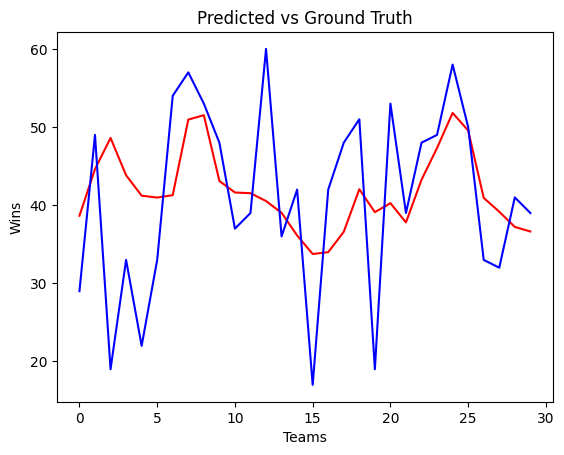

In [788]:
plt.plot(range(len(prediction.flatten())), prediction.flatten(), label='Prediction', color='red')
plt.plot(range(len(ground_truth.flatten())), ground_truth.flatten(), label='Ground Truth', color='blue')
plt.xlabel('Teams')
plt.ylabel('Wins')
plt.title('Predicted vs Ground Truth')

plt.show()
